In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.adamw
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
torch.set_default_device(device)

ds = torchvision.datasets.Flowers102("data/", download=True)
ds[0][0]
print("label for element 0 of data:", ds[0][1])

img_to_tensor = torchvision.transforms.functional.pil_to_tensor
tensor_to_image = torchvision.transforms.functional.to_pil_image
print(img_to_tensor(ds[0][0]).shape)
train_ds = []
img_len = 64

augmentation_transforms = transforms.Compose([
    transforms.Resize((img_len + 8, img_len + 8)),  # Resize to slightly larger
    transforms.RandomCrop((img_len, img_len)),  # Random crop to desired size
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Slight color jittering
    transforms.Resize((img_len, img_len)),
    transforms.ToTensor(),  # Convert to tensor
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] range
])

# Apply augmentation transforms to create train_ds
train_ds = []
for pair in ds:
    train_ds.append(img_to_tensor(pair[0].resize((img_len, img_len))).to(device))
    for x in range(5):
        augmented_img = augmentation_transforms(pair[0]).to(device)
        train_ds.append(augmented_img)
train_ds = torch.stack(train_ds)
train_ds = train_ds.to(device)
train_len = len(train_ds)
print("train examples:", train_len)

class Generator(nn.Module):
    def __init__(self, z_size):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.layers = nn.ModuleList([
            nn.Linear(z_size, z_size * 4),
            nn.LeakyReLU(),
            nn.Linear(z_size*4, z_size * 16),
            nn.LeakyReLU(),
            nn.Linear(z_size*16, z_size* 64),
            nn.LeakyReLU(),
            nn.Linear(z_size*64, img_len * img_len * 3),
            nn.Tanh(),
        ])
        with torch.no_grad():
            self.layers[0].weight.data *= nn.init.calculate_gain("leaky_relu")
            self.layers[2].weight.data *= nn.init.calculate_gain("leaky_relu")
            self.layers[4].weight.data *= nn.init.calculate_gain("tanh")
    def forward(self, ins):
        for layer in self.layers:
            ins = layer(ins)
        return ins

class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.layers = nn.ModuleList([
            nn.Linear(image_size, image_size // 4),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(image_size // 4, image_size // 8),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(image_size // 8, image_size // 16),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(image_size // 16, 1),
            nn.Sigmoid()
        ])
        for layer in self.layers[:-2]:
            if isinstance(layer, nn.Linear):
                with torch.no_grad():
                    layer.weight.data *= torch.nn.init.calculate_gain("leaky_relu")
    def forward(self, ins):
        ins = ins.view(-1, self.image_size)
        for layer in self.layers:
            ins = layer(ins)
        return ins
z_size = 100
my_generator = Generator(z_size)
generated_image = my_generator(torch.randn(2, z_size))
image_size = img_len * img_len * 3
my_discriminator = Discriminator(image_size)
print(my_generator(torch.randn(2, z_size)).shape)
print("discriminator score:", my_discriminator(generated_image))

optim_g = torch.optim.AdamW(my_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = torch.optim.AdamW(my_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


batch_size = 64
max_steps = int((train_len // batch_size) * 100)

my_generator.train()
my_discriminator.train()
for step in range(max_steps):
    idx = torch.randint(0, train_len, (batch_size // 2,))
    dxbr = train_ds[idx]
    noise = torch.randn(batch_size // 2, z_size)
    dxbg = my_generator(noise).view(batch_size //2, image_size)
    dybr = torch.ones(batch_size//2, 1)
    dybg = torch.zeros(batch_size//2, 1)

    g_loss = F.binary_cross_entropy(my_discriminator(dxbg), torch.ones(batch_size // 2, 1))
    g_loss += (sum(p.mean() for p in my_generator.parameters()) / sum(p.numel() for p in my_generator.parameters())) ** 2 * 0.1
    optim_g.zero_grad()

    g_loss.backward()
    torch.nn.utils.clip_grad_norm_(my_generator.parameters(), 0.1)
    optim_g.step()


    optim_d.zero_grad()
    d_loss_real = F.binary_cross_entropy(my_discriminator(dxbr), dybr)
    d_loss_fake= F.binary_cross_entropy(my_discriminator(dxbg.detach()), dybg)
    d_loss = (d_loss_real + d_loss_fake) / 2
    d_loss += (sum(p.mean() for p in my_discriminator.parameters()) / sum(p.numel() for p in my_discriminator.parameters())) ** 2 * 0.1
    d_loss.backward()
    torch.nn.utils.clip_grad_norm_(my_discriminator.parameters(), 0.1)
    optim_d.step()

    if step % 100 == 0:
        print(f"step: {step} | loss g: {g_loss.item():.4f} | loss d: {d_loss.item():.4f}")
        
    
my_generator.eval()
my_discriminator.eval()

noise = torch.randn(1, z_size)
img = tensor_to_image(my_generator(noise).view(3, 64, 64))
img.show()

True
label for element 0 of data: 0
torch.Size([3, 500, 754])
train examples: 6120
torch.Size([2, 12288])
discriminator score: tensor([[0.4984],
        [0.4907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
step: 0 | loss g: 0.6977 | loss d: 0.8136
step: 100 | loss g: 0.5249 | loss d: 0.5155
step: 200 | loss g: 1.0279 | loss d: 5.9511
step: 300 | loss g: 0.3925 | loss d: 0.7167
step: 400 | loss g: 11.2384 | loss d: 0.1393
step: 500 | loss g: 0.0781 | loss d: 1.3984
step: 600 | loss g: 0.1688 | loss d: 1.6262
step: 700 | loss g: 0.7959 | loss d: 2.0687
step: 800 | loss g: 0.9434 | loss d: 1.0649
step: 900 | loss g: 0.9414 | loss d: 1.0611
step: 1000 | loss g: 7.2852 | loss d: 0.0456
step: 1100 | loss g: 0.8456 | loss d: 2.0006
step: 1200 | loss g: 2.2040 | loss d: 2.9376
step: 1300 | loss g: 0.6371 | loss d: 0.6089
step: 1400 | loss g: 3.7079 | loss d: 4.4651
step: 1500 | loss g: 3.5516 | loss d: 1.9011
step: 1600 | loss g: 0.6037 | loss d: 0.7000
step: 1700 | loss g: 0.7239 | loss d:

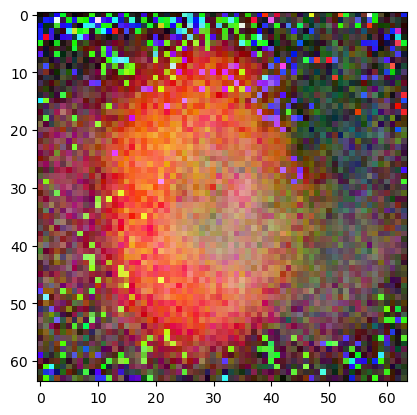

In [20]:
with torch.no_grad():
    noise = torch.randn(1, z_size)
    img = tensor_to_image(my_generator(noise).view(3, 64, 64))
    plt.imshow(img)